In [1]:
import os
import numpy as np
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization

In [2]:
# Re-sizing all the images to this
IMAGE_SIZE = [224, 224]

In [3]:
# Path to the dataset folder
data_path = '/kaggle/input/dermacareai-trainingdataset/datasetskindieases'

In [4]:
class_names = os.listdir(data_path)
num_classes = len(class_names)

total_images = 0  
print(f"Total Classes: {num_classes}")
print("Number of Images per Class:")
for class_name in class_names:
    num_images = len(os.listdir(os.path.join(data_path, class_name)))
    total_images += num_images  
    print(f"{class_name}: {num_images}")

print(f"Total Number of Images: {total_images}")  

Total Classes: 6
Number of Images per Class:
Eczema: 537
Tinea Ringworm Candidiasis: 500
Melanoma: 536
Acne: 500
Actinic Keratosis: 501
Healthy Skin: 537
Total Number of Images: 3111


In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.8, 1.2),
    validation_split=0.2
)
valid_datagen = ImageDataGenerator(
    rescale=1./255,  
    validation_split=0.2  # 20% data for validation
)

In [6]:
# Loading the training and validation data
train_data = train_datagen.flow_from_directory(
    directory=data_path,
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='categorical',
    subset='training',  # 80% for training
)

Found 2484 images belonging to 6 classes.


In [7]:
valid_data = valid_datagen.flow_from_directory(
    directory=data_path,
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='categorical',
    subset='validation',  # 20% for validation
)

Found 620 images belonging to 6 classes.


In [8]:
densenet169 = DenseNet169(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [9]:
densenet169.trainable = False 

In [10]:
# Defining the model architecture
from tensorflow.keras.layers import BatchNormalization
x = tf.keras.layers.GlobalAveragePooling2D()(densenet169.output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)

prediction = Dense(train_data.num_classes, activation='softmax')(x)
model = Model(inputs=densenet169.input, outputs=prediction)

In [11]:
# viewing the structure of the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 13,071,686 (49.86 MB)

 Trainable params: 428,294 (1.63 MB)

 Non-trainable params: 12,643,392 (48.23 MB)

In [12]:
optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
densenet169_history = model.fit(train_data, validation_data=valid_data, epochs=10)

Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.3909 - loss: 1.7721 - val_accuracy: 0.6581 - val_loss: 0.9410
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 46s 539ms/step - accuracy: 0.6838 - loss: 0.9132 - val_accuracy: 0.7726 - val_loss: 0.6387
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 45s 533ms/step - accuracy: 0.7483 - loss: 0.7222 - val_accuracy: 0.8129 - val_loss: 0.5360
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 46s 545ms/step - accuracy: 0.7769 - loss: 0.6157 - val_accuracy: 0.8210 - val_loss: 0.5273
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 46s 535ms/step - accuracy: 0.8197 - loss: 0.5397 - val_accuracy: 0.8274 - val_loss: 0.5185
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 46s 539ms/step - accuracy: 0.8441 - loss: 0.4572 - val_accuracy: 0.8371 - val_loss: 0.5232
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 45s 532ms/step - accuracy: 0.8502 - loss: 0.4289 - val_accuracy: 0.8371 - val_loss: 0.4921
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 46s 536ms/step - accuracy: 0.8404 - loss: 0.4507 - val_accurac

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# training and validation accuracy and loss
def plot_history(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# confusion matrix
def plot_confusion_matrix(model, generator):
    
    val_labels = np.concatenate([generator.__next__()[1] for _ in range(len(generator))])  
    val_labels = np.argmax(val_labels, axis=1)

    val_preds = model.predict(generator)
    val_preds = np.argmax(val_preds, axis=1)

    # Confusion matrix
    cm = confusion_matrix(val_labels, val_preds)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification report
    print('Classification Report')
    report = classification_report(val_labels, val_preds, target_names=generator.class_indices.keys(), zero_division=0)
    print(report)

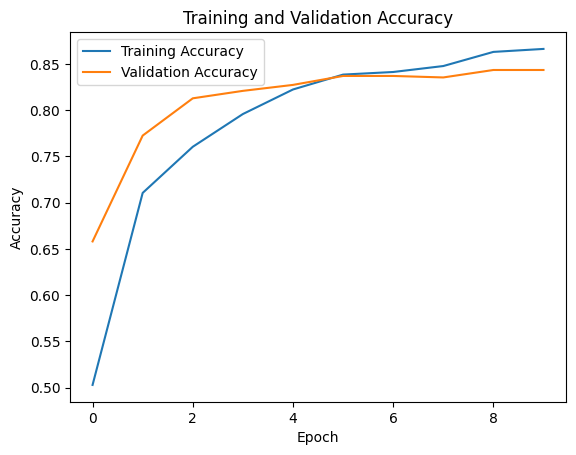

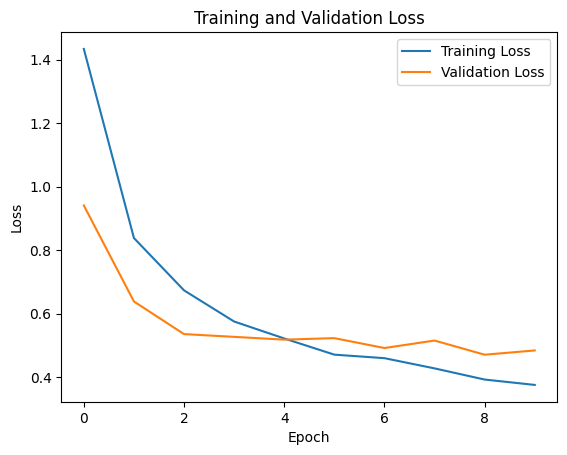

20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 759ms/step


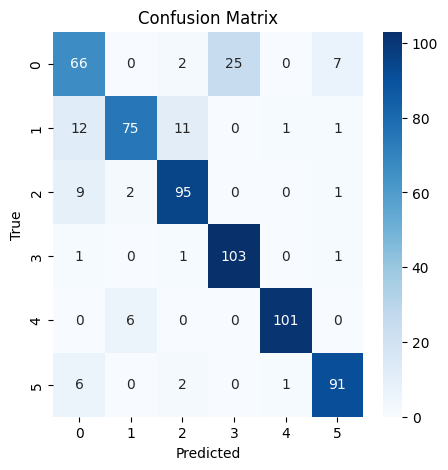

Classification Report
                            precision    recall  f1-score   support

                      Acne       0.70      0.66      0.68       100
         Actinic Keratosis       0.90      0.75      0.82       100
                    Eczema       0.86      0.89      0.87       107
              Healthy Skin       0.80      0.97      0.88       106
                  Melanoma       0.98      0.94      0.96       107
Tinea Ringworm Candidiasis       0.90      0.91      0.91       100

                  accuracy                           0.86       620
                 macro avg       0.86      0.85      0.85       620
              weighted avg       0.86      0.86      0.85       620



In [19]:
# Plot history and confusion matrix
plot_history(densenet169_history)
plot_confusion_matrix(model, valid_data)

In [20]:
model.save('densenet169_final_model.h5')


**DenseNet169 Model evaluation on unseen data:** 8 out of 12 correct predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


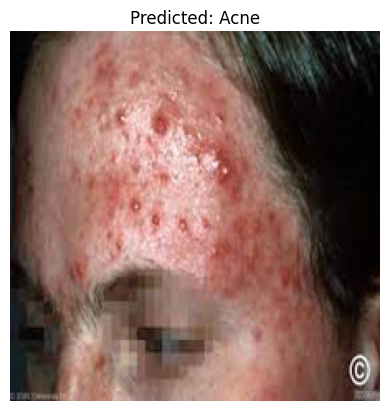

Model Prediction: Acne


In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image 


model = load_model('/kaggle/working/densenet169_final_model.h5')

class_names = list(train_data.class_indices.keys())  

def predict_image(image_path, model, class_names):
 
    if not os.path.exists(image_path):
        print(f"Error: The file '{image_path}' does not exist.")
        return None

    try:
        img = Image.open(image_path).convert("RGB")  
        img = img.resize((224, 224))  
        img = img_to_array(img) / 255.0  
        img = np.expand_dims(img, axis=0)  
      
        prediction = model.predict(img)
        predicted_class = np.argmax(prediction)  
        predicted_label = class_names[predicted_class] 


        plt.imshow(img[0])  
        plt.title(f"Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

        return predicted_label

    except Exception as e:
        print(f"Error loading image: {e}")
        return None


image_path = "/kaggle/input/dermacareai-testdataset/Sample_dataset/acne_test_sample.jpg" 
predicted_class = predict_image(image_path, model, class_names)

if predicted_class:
    print(f"Model Prediction: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


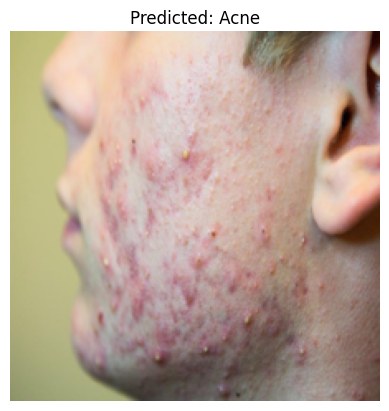

Model Prediction: Acne


In [24]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image 


model = load_model('/kaggle/working/densenet169_final_model.h5')

class_names = list(train_data.class_indices.keys())  

def predict_image(image_path, model, class_names):
 
    if not os.path.exists(image_path):
        print(f"Error: The file '{image_path}' does not exist.")
        return None

    try:
        img = Image.open(image_path).convert("RGB")  
        img = img.resize((224, 224))  
        img = img_to_array(img) / 255.0  
        img = np.expand_dims(img, axis=0)  
      
        prediction = model.predict(img)
        predicted_class = np.argmax(prediction)  
        predicted_label = class_names[predicted_class] 

       
        plt.imshow(img[0])  
        plt.title(f"Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

        return predicted_label

    except Exception as e:
        print(f"Error loading image: {e}")
        return None


image_path = "/kaggle/input/dermacareai-testdataset/Sample_dataset/acne_test_sample2.jpg" 
predicted_class = predict_image(image_path, model, class_names)

if predicted_class:
    print(f"Model Prediction: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


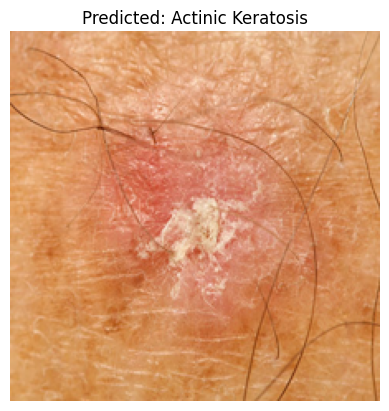

Model Prediction: Actinic Keratosis


In [25]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image 


model = load_model('/kaggle/working/densenet169_final_model.h5')

class_names = list(train_data.class_indices.keys())  

def predict_image(image_path, model, class_names):
 
    if not os.path.exists(image_path):
        print(f"Error: The file '{image_path}' does not exist.")
        return None

    try:
        img = Image.open(image_path).convert("RGB")  
        img = img.resize((224, 224))  
        img = img_to_array(img) / 255.0  
        img = np.expand_dims(img, axis=0)  
       
        prediction = model.predict(img)
        predicted_class = np.argmax(prediction)  
        predicted_label = class_names[predicted_class] 

        plt.imshow(img[0])  
        plt.title(f"Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

        return predicted_label

    except Exception as e:
        print(f"Error loading image: {e}")
        return None


image_path = "/kaggle/input/dermacareai-testdataset/Sample_dataset/actinic-keratosis_test_sample.jpg" 
predicted_class = predict_image(image_path, model, class_names)

if predicted_class:
    print(f"Model Prediction: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


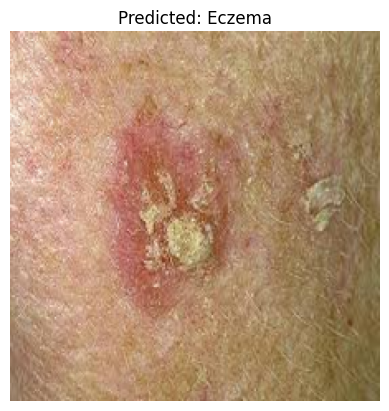

Model Prediction: Eczema


In [26]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image 

model = load_model('/kaggle/working/densenet169_final_model.h5')

class_names = list(train_data.class_indices.keys())  

def predict_image(image_path, model, class_names):
 
    if not os.path.exists(image_path):
        print(f"Error: The file '{image_path}' does not exist.")
        return None

    try:
        img = Image.open(image_path).convert("RGB")  
        img = img.resize((224, 224))  
        img = img_to_array(img) / 255.0  
        img = np.expand_dims(img, axis=0)  
     
        prediction = model.predict(img)
        predicted_class = np.argmax(prediction)  
        predicted_label = class_names[predicted_class] 

     
        plt.imshow(img[0])  
        plt.title(f"Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

        return predicted_label

    except Exception as e:
        print(f"Error loading image: {e}")
        return None


image_path = "/kaggle/input/dermacareai-testdataset/Sample_dataset/actinic-keratosis_test_sample2.jpg" 
predicted_class = predict_image(image_path, model, class_names)

if predicted_class:
    print(f"Model Prediction: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


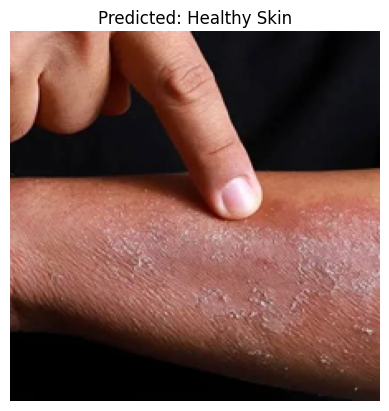

Model Prediction: Healthy Skin


In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image 


model = load_model('/kaggle/working/densenet169_final_model.h5')

class_names = list(train_data.class_indices.keys())  

def predict_image(image_path, model, class_names):
 
    if not os.path.exists(image_path):
        print(f"Error: The file '{image_path}' does not exist.")
        return None

    try:
        img = Image.open(image_path).convert("RGB")  
        img = img.resize((224, 224))  
        img = img_to_array(img) / 255.0  
        img = np.expand_dims(img, axis=0)  
  
        prediction = model.predict(img)
        predicted_class = np.argmax(prediction)  
        predicted_label = class_names[predicted_class] 

    
        plt.imshow(img[0])  
        plt.title(f"Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

        return predicted_label

    except Exception as e:
        print(f"Error loading image: {e}")
        return None


image_path = "/kaggle/input/dermacareai-testdataset/Sample_dataset/eczema_test_sample.jpg" 
predicted_class = predict_image(image_path, model, class_names)

if predicted_class:
    print(f"Model Prediction: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


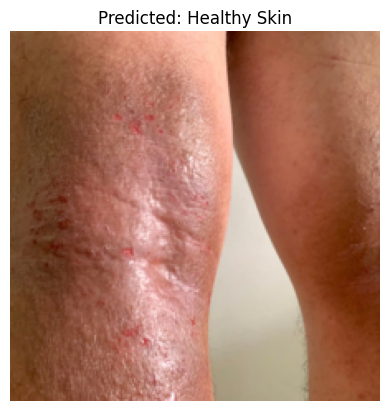

Model Prediction: Healthy Skin


In [28]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image 


model = load_model('/kaggle/working/densenet169_final_model.h5')

class_names = list(train_data.class_indices.keys())  

def predict_image(image_path, model, class_names):
 
    if not os.path.exists(image_path):
        print(f"Error: The file '{image_path}' does not exist.")
        return None

    try:
        img = Image.open(image_path).convert("RGB")  
        img = img.resize((224, 224))  
        img = img_to_array(img) / 255.0  
        img = np.expand_dims(img, axis=0)  
  
        prediction = model.predict(img)
        predicted_class = np.argmax(prediction)  
        predicted_label = class_names[predicted_class] 

     
        plt.imshow(img[0])  
        plt.title(f"Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

        return predicted_label

    except Exception as e:
        print(f"Error loading image: {e}")
        return None


image_path = "/kaggle/input/dermacareai-testdataset/Sample_dataset/eczema_test_sample2.jpg" 
predicted_class = predict_image(image_path, model, class_names)

if predicted_class:
    print(f"Model Prediction: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


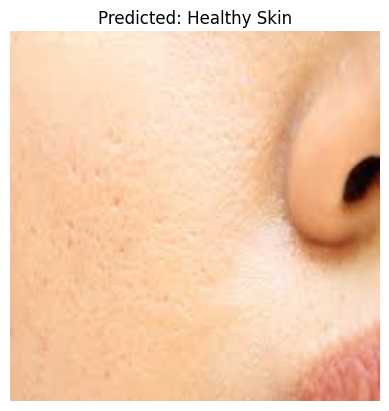

Model Prediction: Healthy Skin


In [29]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image 


model = load_model('/kaggle/working/densenet169_final_model.h5')

class_names = list(train_data.class_indices.keys())  

def predict_image(image_path, model, class_names):
 
    if not os.path.exists(image_path):
        print(f"Error: The file '{image_path}' does not exist.")
        return None

    try:
        img = Image.open(image_path).convert("RGB")  
        img = img.resize((224, 224))  
        img = img_to_array(img) / 255.0  
        img = np.expand_dims(img, axis=0)  
      
        prediction = model.predict(img)
        predicted_class = np.argmax(prediction)  
        predicted_label = class_names[predicted_class] 

        
        plt.imshow(img[0])  
        plt.title(f"Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

        return predicted_label

    except Exception as e:
        print(f"Error loading image: {e}")
        return None


image_path = "/kaggle/input/dermacareai-testdataset/Sample_dataset/healthyskin_test_sample.jpg" 
predicted_class = predict_image(image_path, model, class_names)

if predicted_class:
    print(f"Model Prediction: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


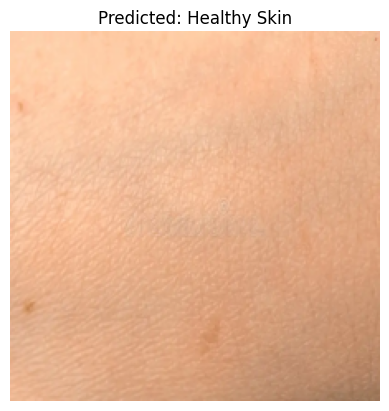

Model Prediction: Healthy Skin


In [30]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image 


model = load_model('/kaggle/working/densenet169_final_model.h5')

class_names = list(train_data.class_indices.keys())  

def predict_image(image_path, model, class_names):
 
    if not os.path.exists(image_path):
        print(f"Error: The file '{image_path}' does not exist.")
        return None

    try:
        img = Image.open(image_path).convert("RGB")  
        img = img.resize((224, 224))  
        img = img_to_array(img) / 255.0  
        img = np.expand_dims(img, axis=0)  
   
        prediction = model.predict(img)
        predicted_class = np.argmax(prediction)  
        predicted_label = class_names[predicted_class] 

    
        plt.imshow(img[0])  
        plt.title(f"Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

        return predicted_label

    except Exception as e:
        print(f"Error loading image: {e}")
        return None


image_path = "/kaggle/input/dermacareai-testdataset/Sample_dataset/healthyskin_test_sample2.jpg" 
predicted_class = predict_image(image_path, model, class_names)

if predicted_class:
    print(f"Model Prediction: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


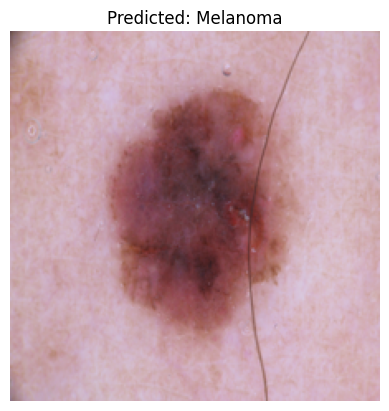

Model Prediction: Melanoma


In [31]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image 


model = load_model('/kaggle/working/densenet169_final_model.h5')

class_names = list(train_data.class_indices.keys())  

def predict_image(image_path, model, class_names):
 
    if not os.path.exists(image_path):
        print(f"Error: The file '{image_path}' does not exist.")
        return None

    try:
        img = Image.open(image_path).convert("RGB")  
        img = img.resize((224, 224))  
        img = img_to_array(img) / 255.0  
        img = np.expand_dims(img, axis=0)  
    
        prediction = model.predict(img)
        predicted_class = np.argmax(prediction)  
        predicted_label = class_names[predicted_class] 

     
        plt.imshow(img[0])  
        plt.title(f"Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

        return predicted_label

    except Exception as e:
        print(f"Error loading image: {e}")
        return None


image_path = "/kaggle/input/dermacareai-testdataset/Sample_dataset/melanoma_test_sample.jpg" 
predicted_class = predict_image(image_path, model, class_names)

if predicted_class:
    print(f"Model Prediction: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


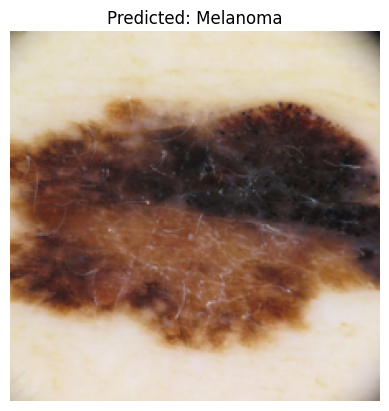

Model Prediction: Melanoma


In [32]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image 


model = load_model('/kaggle/working/densenet169_final_model.h5')

class_names = list(train_data.class_indices.keys())  

def predict_image(image_path, model, class_names):
 
    if not os.path.exists(image_path):
        print(f"Error: The file '{image_path}' does not exist.")
        return None

    try:
        img = Image.open(image_path).convert("RGB")  
        img = img.resize((224, 224))  
        img = img_to_array(img) / 255.0  
        img = np.expand_dims(img, axis=0)  
  
        prediction = model.predict(img)
        predicted_class = np.argmax(prediction)  
        predicted_label = class_names[predicted_class] 

    
        plt.imshow(img[0])  
        plt.title(f"Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

        return predicted_label

    except Exception as e:
        print(f"Error loading image: {e}")
        return None


image_path = "/kaggle/input/dermacareai-testdataset/Sample_dataset/melanoma_test_sample2.JPG" 
predicted_class = predict_image(image_path, model, class_names)

if predicted_class:
    print(f"Model Prediction: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


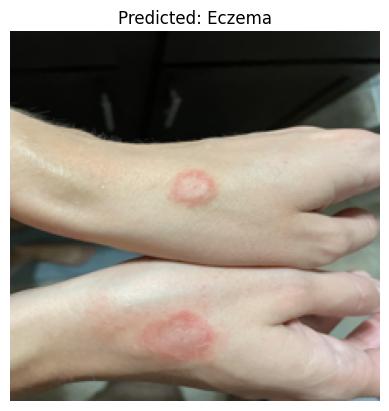

Model Prediction: Eczema


In [33]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image 


model = load_model('/kaggle/working/densenet169_final_model.h5')

class_names = list(train_data.class_indices.keys())  

def predict_image(image_path, model, class_names):
 
    if not os.path.exists(image_path):
        print(f"Error: The file '{image_path}' does not exist.")
        return None

    try:
        img = Image.open(image_path).convert("RGB")  
        img = img.resize((224, 224))  
        img = img_to_array(img) / 255.0  
        img = np.expand_dims(img, axis=0)  
      
        prediction = model.predict(img)
        predicted_class = np.argmax(prediction)  
        predicted_label = class_names[predicted_class] 

        plt.imshow(img[0])  
        plt.title(f"Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

        return predicted_label

    except Exception as e:
        print(f"Error loading image: {e}")
        return None


image_path = "/kaggle/input/dermacareai-testdataset/Sample_dataset/ringworm_test_sample.jpg" 
predicted_class = predict_image(image_path, model, class_names)

if predicted_class:
    print(f"Model Prediction: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


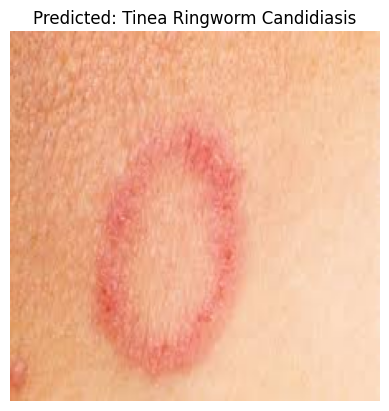

Model Prediction: Tinea Ringworm Candidiasis


In [34]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image 


model = load_model('/kaggle/working/densenet169_final_model.h5')

class_names = list(train_data.class_indices.keys())  

def predict_image(image_path, model, class_names):
 
    if not os.path.exists(image_path):
        print(f"Error: The file '{image_path}' does not exist.")
        return None

    try:
        img = Image.open(image_path).convert("RGB")  
        img = img.resize((224, 224))  
        img = img_to_array(img) / 255.0  
        img = np.expand_dims(img, axis=0)  
       
        prediction = model.predict(img)
        predicted_class = np.argmax(prediction)  
        predicted_label = class_names[predicted_class] 

      
        plt.imshow(img[0])  
        plt.title(f"Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

        return predicted_label

    except Exception as e:
        print(f"Error loading image: {e}")
        return None


image_path = "/kaggle/input/dermacareai-testdataset/Sample_dataset/ringworm_test_sample2.jpg" 
predicted_class = predict_image(image_path, model, class_names)

if predicted_class:
    print(f"Model Prediction: {predicted_class}")